## EDA

In [1]:
import os
import glob
import pathlib
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
dataset_path = '/media/alex/80CA308ECA308288/alex_dataset/scene_classification'

In [3]:
dataset_dir = pathlib.Path(dataset_path)

labels_path = list(dataset_dir.glob('./*.csv'))[0]

train_images = os.path.join(dataset_path, 'train')
test_images = os.path.join(dataset_path, 'train')

images_labels = pd.read_csv(labels_path, sep=',', header=0)

train_labels = images_labels['label']

labels_count = train_labels.value_counts(sort=False)

print(labels_count)

sea          2201
buildings    2109
street       2322
mountain     2434
forest       2210
glacier      2351
Name: label, dtype: int64


In [4]:
category = sorted(set(train_labels.values.tolist()))

class_index = {c:i for i, c in enumerate(category)}
index_class = {i:c for i, c in enumerate(category)}

print(class_index)
print(index_class)


{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


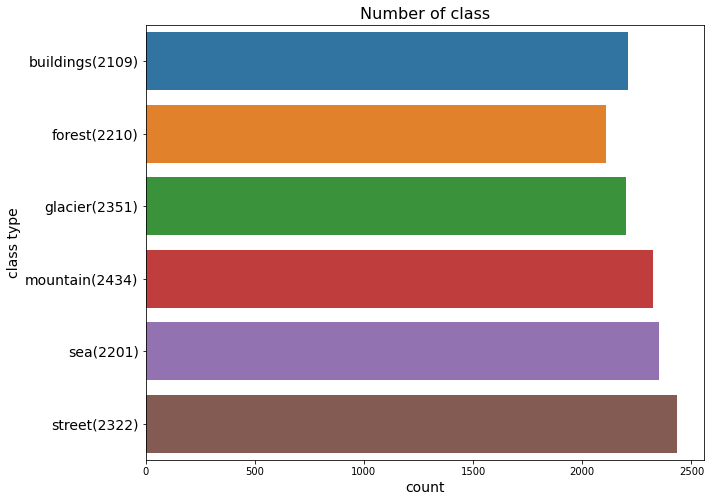

Done


In [5]:
# get yticks label
yticks_label = ['{0}({1})'.format(c, labels_count[c]) for c in class_index.keys()]

plt.figure(figsize=(10, 8))
sns.countplot(y=train_labels, hue_order=class_index.keys())
# sns.countplot(y=train_labels, hue_order=class_index.keys())

# sns.barplot(x=class_count.index, y=class_count.values)
plt.title('Number of class', fontsize=16)
plt.xlabel('count', fontsize=14)
plt.ylabel('class type', fontsize=14)
plt.yticks(range(len(yticks_label)), yticks_label, fontsize=14)
plt.show()


print('Done')

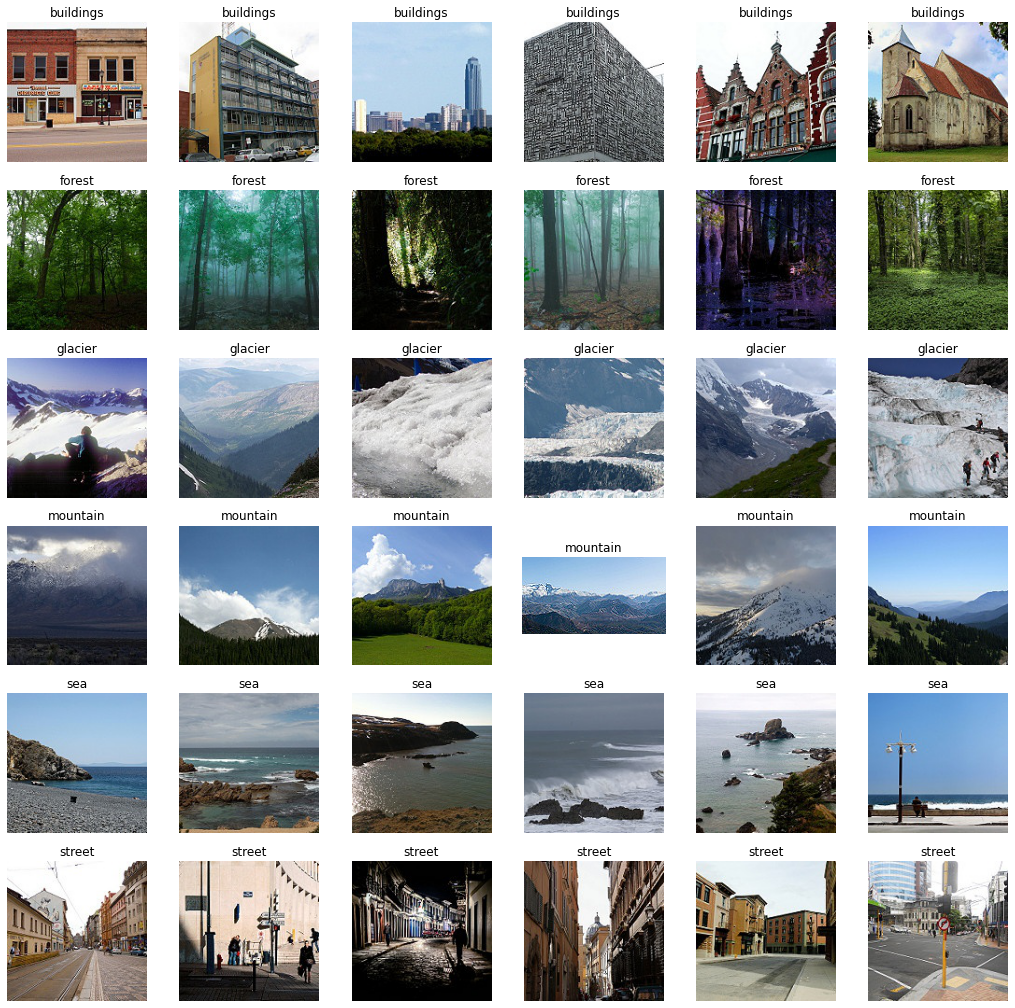

In [6]:
sub_buildings = images_labels[images_labels['label'] == index_class[0]]['filename'].iloc[:6].to_list()
sub_forest = images_labels[images_labels['label'] == index_class[1]]['filename'].iloc[:6].to_list()
sub_glacier = images_labels[images_labels['label'] == index_class[2]]['filename'].iloc[:6].to_list()
sub_mountain = images_labels[images_labels['label'] == index_class[3]]['filename'].iloc[:6].to_list()
sub_sea = images_labels[images_labels['label'] == index_class[4]]['filename'].iloc[:6].to_list()
sub_street = images_labels[images_labels['label'] == index_class[5]]['filename'].iloc[:6].to_list()

sample_images = sub_buildings + sub_forest + sub_glacier+ sub_mountain + sub_sea + sub_street
sample_labels = [0] * 6 + [1] *6 + [2] * 6 + [3] * 6 + [4] * 6 + [5] * 6


fig, ax = plt.subplots(6, 6, figsize=(18, 18))
for n, (img_name, img_label) in enumerate(zip(sample_images, sample_labels)):
    plt.subplot(6, 6, n+1)
    plt.imshow(np.array(Image.open(os.path.join(train_images, img_name))))
    plt.title(index_class[img_label])
    plt.axis('off')
plt.show()